In [1]:
import numpy as np
import networkx as nx
import random
from collections import defaultdict
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.interpolate import interp1d
import scipy
%matplotlib inline

In [2]:
class _ListDict_(object):
    
    def __init__(self):
        self.item_to_position = {}
        self.items = []

    def __len__(self):
        return len(self.items)

    def add(self, item):
        if item in self.item_to_position:
            return
        self.items.append(item)
        self.item_to_position[item] = len(self.items)-1

    def remove(self, item):
        if item in self.item_to_position:
            position = self.item_to_position.pop(item)
            del self.items[position]
            for i in range(len(self.items)):
                if i >= position:
                    self.item_to_position[self.items[i]] = self.item_to_position[self.items[i]] - 1
        
        #last_item = self.items.pop()
        #if position != len(self.items):
        #    self.items[position] = last_item
        #    self.item_to_position[last_item] = position

    def choose_random(self):
        return random.choice(self.items)
    
    def __repr__(self):
         return repr(self.items)

    def __str__(self):
         return str(self.items)

In [3]:
def initialize_SIS(G, initial_infecteds, infection_times, 
                                recovery_times, tmin, return_full_data):
    '''Initializes the network'''
    times = [tmin]
    S = [G.order()-len(initial_infecteds)]
    I = [len(initial_infecteds)]
    status = defaultdict(lambda:'S') #by default all are susceptible
    infected = list(initial_infecteds)
    infected_neighbor_count = defaultdict(lambda:0)
    risk_group = defaultdict(lambda:_ListDict_()) 
    for node in initial_infecteds:
        status[node] = 'I'
    for node in initial_infecteds:
        for neighbor in G.neighbors(node):
            if status[neighbor] == 'S':
                infected_neighbor_count[neighbor] += 1
                if infected_neighbor_count[neighbor]>1:
                    risk_group[infected_neighbor_count[neighbor]-1].remove(
                                                                    neighbor)
                risk_group[infected_neighbor_count[neighbor]].add(neighbor)

    if return_full_data:
        for node in initial_infecteds:
            infection_times[node] = [tmin]
    return times, S, I, status, infected, infected_neighbor_count, risk_group

In [4]:
def infect(G, S, I, R, times, infected, current_time, 
                        infected_neighbor_count, risk_group, status, 
                        infection_times, return_full_data, SIR=True):
    r = random.random()*sum(n*len(risk_group[n]) for n in risk_group.keys())
    for n in risk_group.keys():
        r-= n*len(risk_group[n])
        if r<0:
            break
    #we've got n now

    recipient = risk_group[n].choose_random()
    assert(status[recipient]=='S')
    risk_group[n].remove(recipient)
    infected.append(recipient)
    infection_times[recipient].append(current_time)
    status[recipient]='I'
    S.append(S[-1]-1)
    I.append(I[-1]+1)
    times.append(current_time)
    if SIR:
        R.append(R[-1])

    for neighbor in G.neighbors(recipient):
        if status[neighbor]=='S':
            if infected_neighbor_count[neighbor]>0:
                risk_group[infected_neighbor_count[neighbor]].remove(neighbor)
            infected_neighbor_count[neighbor]+=1
            risk_group[infected_neighbor_count[neighbor]].add(neighbor)

In [5]:
def recover(G, S, I, times, infected, current_time, status, 
                            infected_neighbor_count, risk_group, 
                            recovery_times, return_full_data):
    assert(I[-1]==len(infected))
    index = random.randint(0,I[-1]-1)
    infected[index], infected[-1] = infected[-1], infected[index] 
                    #http://stackoverflow.com/a/14088129/2966723
    recovering_node = infected.pop()

    I.append(I[-1]-1)
    status[recovering_node]='S'
    S.append(S[-1]+1)
    times.append(current_time)
    infected_neighbor_count[recovering_node] = 0
    for neighbor in G.neighbors(recovering_node):
        if neighbor == recovering_node:
            continue  #Deals with selfloops
                      #there is probably a good way to count the 
                      #number of infected neighbors
        if status[neighbor] == 'I':
            infected_neighbor_count[recovering_node] += 1
        else: #neighbor susceptible, its risk just got smaller
            risk_group[infected_neighbor_count[neighbor]].remove(neighbor)
            infected_neighbor_count[neighbor] -= 1
            if infected_neighbor_count[neighbor]>0:
                risk_group[infected_neighbor_count[neighbor]].add(neighbor)
    if infected_neighbor_count[recovering_node]>0:
        risk_group[infected_neighbor_count[recovering_node]].add(
                                                            recovering_node)
    if return_full_data:
        recovery_times[recovering_node].append(current_time)


In [6]:
def SIS(G, tau, gamma, initial_infecteds=None, rho = None, tmin = 0,
                    tmax=100, return_full_data = False):

    infection_times = defaultdict(lambda: []) #defaults to an empty list 
    recovery_times = defaultdict(lambda: [])  #for each node

    tau = float(tau)  #just to avoid integer division problems.
    gamma = float(gamma)
    
    if initial_infecteds is None:
        if rho is None:
            initial_number = 1
        else:
            initial_number = int(round(G.order()*rho))
        initial_infecteds=random.sample(G.nodes(), initial_number)
    elif G.has_node(initial_infecteds):
        initial_infecteds=[initial_infecteds]
        
    times, S, I, status, infected, infected_neighbor_count, risk_group = \
                initialize_SIS(G, initial_infecteds, infection_times,  
                                        recovery_times, tmin, return_full_data)
        
    total_trans_rate = tau*sum(n*len(risk_group[n]) 
                                    for n in risk_group.keys())
    total_rec_rate = gamma*len(infected)
    total_rate = total_rec_rate + total_trans_rate
    next_time = times[-1] + random.expovariate(total_rate)
    while next_time<tmax and infected:
        r = random.random()*total_rate
        if r<total_rec_rate:
            recover(G, S, I, times, infected, next_time, 
                                    status, infected_neighbor_count, 
                                    risk_group, recovery_times, 
                                    return_full_data)
            total_rec_rate = gamma*I[-1]
        else:
            infect(G, S, I, [], times, infected, next_time, 
                                infected_neighbor_count, risk_group, status, 
                                infection_times, return_full_data, SIR=False)
        total_trans_rate = tau*sum(n*len(risk_group[n]) 
                                    for n in risk_group.keys())
        total_rate = total_rec_rate + total_trans_rate
        if total_rate>0:
            next_time += random.expovariate(total_rate)
        else:
            next_time = float('Inf')

    if not return_full_data:
        return scipy.array(times), scipy.array(S), scipy.array(I)

## Пример 1

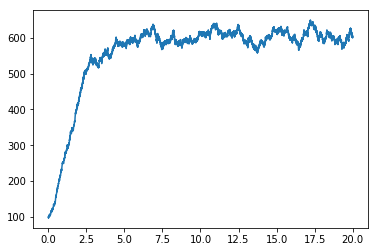

In [14]:
G = nx.erdos_renyi_graph(1000, 0.05)
initial_size = 100
gamma = 1.
tau = 0.05
t, S, I = SIS(G, tau, gamma, tmax = 20, initial_infecteds = range(initial_size))

plt.plot(t, I)

In [10]:
def get_stability_time(inf_arr, num_steps, interval, eps, threshold):
    count = 0
    stab_time = num_steps
    for i, j in zip(np.arange(0, num_steps - interval, 1), np.arange(interval, num_steps, 1)):
        if abs(inf_arr[j] - inf_arr[i]) < eps:
            count += 1
        else:
            count = 0
        if count > threshold:
            stab_time = i
            break
    return stab_time        

In [108]:
stab_time = get_stability_time(I, len(t), 100, 0.1, 5)
t[stab_time - 1]

2.8424202300647026

## Пример 2

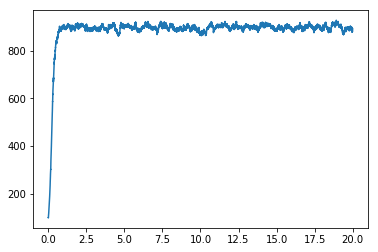

In [109]:
G = nx.erdos_renyi_graph(1000, 0.05)
initial_size = 100
gamma = 1.
tau = 0.2
t, S, I = Gillespie_SIS(G, tau, gamma, tmax = 20,
                        initial_infecteds = range(initial_size))

plt.plot(t, I)

In [112]:
stab_time = get_stability_time(I, len(t), 100, 0.1, 5)
t[stab_time - 1]

1.2863774773504808

## Ансабль из 100 сетей

In [8]:
network_arr = np.arange(100)
N = 1000
p = 0.05
G_ensemble = []
for _ in network_arr:
    G_ensemble.append(nx.erdos_renyi_graph(N, p))

### Построим зависимость времени стабилизации от вероятности заражения

In [11]:
p_inf_arr = np.linspace(0.01, 0.2, 20)
p_inf_arr

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ])

In [12]:
initial_size = 100
gamma = 1.
t_stab = []
std_arr = []
for prob in p_inf_arr:
    print("--------------------------------")
    print("infection probability: ", prob)
    
    inf_array = []
    stab_time_arr = []
    for g in G_ensemble:
        t, S, I = SIS(g, prob, gamma, tmax = 20, initial_infecteds = range(initial_size))
        stab_time = get_stability_time(I, len(t), 100, 0.1, 5)
        stab_time_arr.append(t[stab_time - 1])
    
    t_stab.append(np.mean(stab_time_arr))
    std_arr.append(np.std(stab_time_arr))

--------------------------------
infection probability:  0.01
--------------------------------
infection probability:  0.02
--------------------------------
infection probability:  0.03
--------------------------------
infection probability:  0.04
--------------------------------
infection probability:  0.05
--------------------------------
infection probability:  0.060000000000000005
--------------------------------
infection probability:  0.06999999999999999
--------------------------------
infection probability:  0.08
--------------------------------
infection probability:  0.09
--------------------------------
infection probability:  0.09999999999999999
--------------------------------
infection probability:  0.11
--------------------------------
infection probability:  0.12
--------------------------------
infection probability:  0.13
--------------------------------
infection probability:  0.14
--------------------------------
infection probability:  0.15000000000000002
---------

In [15]:
f1 = interp1d(p_inf_arr, t_stab)
f2 = interp1d(p_inf_arr, t_stab, kind='cubic')

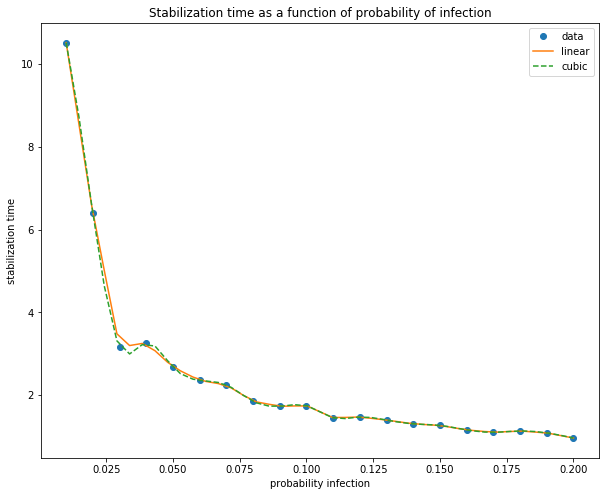

In [16]:
f1 = interp1d(p_inf_arr, t_stab)
f2 = interp1d(p_inf_arr, t_stab, kind='cubic')
f = plt.figure(figsize=(10,8))
xnew = np.linspace(0.01, 0.2, num=41, endpoint=True)
plt.title('Stabilization time as a function of probability of infection')
plt.xlabel('probability infection')
plt.ylabel('stabilization time')
plt.plot(p_inf_arr, t_stab, 'o', xnew, f1(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

Text(0,0.5,'stabilization time')

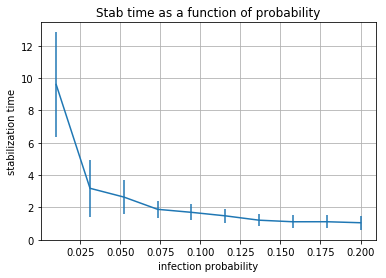

In [38]:
fig, ax = plt.subplots()
ax.errorbar(p_inf_arr, t_stab, yerr = std_arr)
ax.grid(True)
ax.set_title('Stab time as a function of probability')
ax.set_xlabel('infection probability')
ax.set_ylabel('stabilization time')

### Зависимость доли зараженных в момент стабилизации от вероятности заражения

In [17]:
p_inf_arr = np.linspace(0.002, 0.2, 20)

initial_size = 100
gamma = 1.
t_stab = []
t_arr = []
inf_frac = []
std_arr = []
for prob in p_inf_arr:
    print("--------------------------------")
    print("infection probability: ", prob)
    
    inf_array = []
    t_array = []
    for g in G_ensemble:
        t, S, I = SIS(g, prob, gamma, tmax = 20, initial_infecteds = range(initial_size))
        inf_array.append(I.tolist())
        t_array.append(t.tolist())
    
    #bug-fix: заполняем последними значениями списки зараженных для единообразия
    max_len_inf = max([len(arr) for arr in inf_array])
    for arr in inf_array:
        if len(arr) < max_len_inf:
            last_elem = arr[-1]
            for j in range(max_len_inf - len(arr)):
                arr.append(last_elem)
    
    #возьмем время с максимальной длиной
    t_max_len = [len(arr) for arr in t_array].index(max([len(arr) for arr in t_array]))
    t_arr.append(t_array[t_max_len])
    
    
    ens_inf = np.stack((inf_array), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    std = [np.std(lst) for lst in ens_inf]
    stab_time = get_stability_time(avrg_inf, len(t), 100, 0.1, 5)

    t_stab.append(stab_time)
    inf_frac.append(avrg_inf)
    std_arr.append(std)

--------------------------------
infection probability:  0.002
--------------------------------
infection probability:  0.012421052631578947
--------------------------------
infection probability:  0.022842105263157893
--------------------------------
infection probability:  0.03326315789473684
--------------------------------
infection probability:  0.04368421052631579
--------------------------------
infection probability:  0.05410526315789474
--------------------------------
infection probability:  0.06452631578947368
--------------------------------
infection probability:  0.07494736842105264
--------------------------------
infection probability:  0.08536842105263158
--------------------------------
infection probability:  0.09578947368421052
--------------------------------
infection probability:  0.10621052631578948
--------------------------------
infection probability:  0.11663157894736842
--------------------------------
infection probability:  0.12705263157894736
-----------

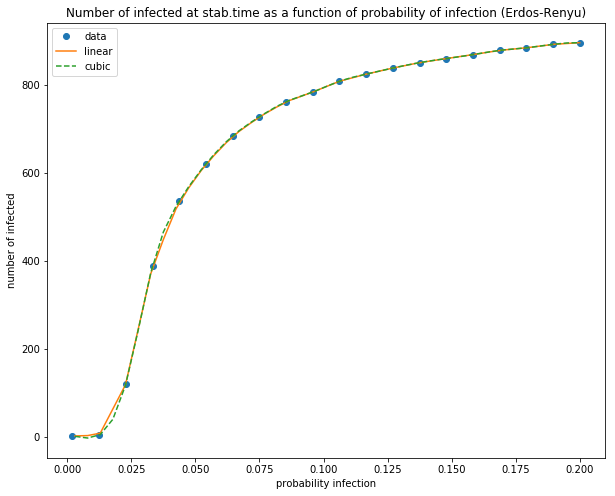

In [27]:
f1 = interp1d(p_inf_arr, frac_arr)
f2 = interp1d(p_inf_arr, frac_arr, kind='cubic')

f = plt.figure(figsize=(10,8))
xnew = np.linspace(0.003, 0.2, num=41, endpoint=True)
plt.title('Number of infected at stab.time as a function of probability of infection (Erdos-Renyu)')
plt.xlabel('probability infection')
plt.ylabel('number of infected')
plt.plot(p_inf_arr, frac_arr, 'o', xnew, f1(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

In [20]:
frac_arr = []
std_at_stab_time = []
for i, arr in enumerate(inf_frac):
    frac_arr.append(arr[t_stab[i]])
    std_at_stab_time.append(std[t_stab[i]])

In [23]:
std_at_stab_time

[7.997499609252881,
 10.72559555456013,
 10.430167783885361,
 10.00517865907451,
 10.23208678618394,
 10.14802443828354,
 9.818574234582128,
 9.562426470305535,
 9.901595830975934,
 11.651248860100791]

Text(0,0.5,'% of infected')

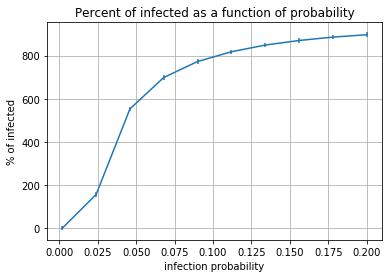

In [26]:
fig, ax = plt.subplots()
ax.errorbar(p_inf_arr, frac_arr, yerr = std_at_stab_time)
ax.grid(True)
ax.set_title('Percent of infected as a function of probability')
ax.set_xlabel('infection probability')
ax.set_ylabel('% of infected')

## Adjacency matrix and eigenvalue

In [304]:
G = nx.erdos_renyi_graph(5000, 0.05)
A = nx.adjacency_matrix(G)
A = A.todense()
max_eigval = max(LA.eigvalsh(A))

In [305]:
max_eigval

251.59488749626894

Epidemic threshold $\tau = \frac{1}{251} = 0.0039$

In [39]:
tau_arr = np.linspace(0.0001, 0.01, 10)
tau_arr

array([0.0001, 0.0012, 0.0023, 0.0034, 0.0045, 0.0056, 0.0067, 0.0078,
       0.0089, 0.01  ])

In [307]:
initial_size = 100
gamma = 1.
tau = 0.004
I_arr, t_arr = [], []
for tau in (tau_arr):
    t, S, I = Gillespie_SIS(G, tau, gamma, tmax = 20,
                        initial_infecteds = range(initial_size))
    I_arr.append(I)
    t_arr.append(t)

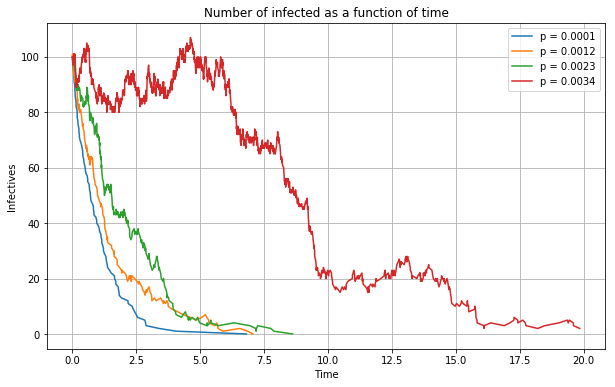

In [308]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_arr[0], I_arr[0], label='p = 0.0001')

ax.plot(t_arr[1], I_arr[1], label='p = 0.0012')

ax.plot(t_arr[2], I_arr[2], label='p = 0.0023')

ax.plot(t_arr[3], I_arr[3], label='p = 0.0034')

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

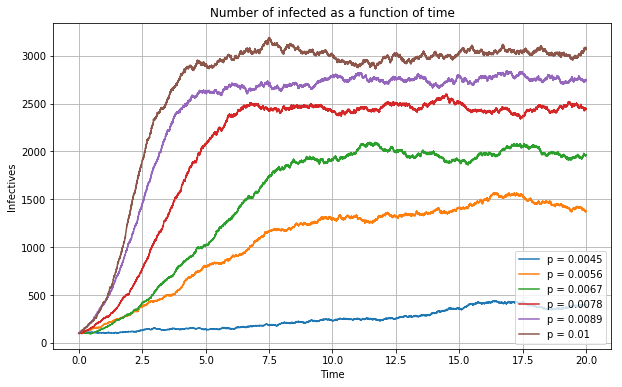

In [309]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_arr[4], I_arr[4], label='p = 0.0045')

ax.plot(t_arr[5], I_arr[5], label='p = 0.0056')

ax.plot(t_arr[6], I_arr[6], label='p = 0.0067')

ax.plot(t_arr[7], I_arr[7], label='p = 0.0078')

ax.plot(t_arr[8], I_arr[8], label='p = 0.0089')

ax.plot(t_arr[9], I_arr[9], label='p = 0.01')

ax.legend(loc='lower right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()


## Exponential decay:
Если epidemic threshold $\tau < \tau_c$, то число зараженных убывает экспоненциально

In [40]:
initial_size = 100
gamma = 1.
tau = 0.004
I_arr, t_arr = [], []
for tau in (tau_arr):
    I_tmp = []
    t_tmp = []
    for G in G_ensemble:
        t, S, I = SIS(G, tau, gamma, tmax = 20, initial_infecteds = range(initial_size))
        I_tmp.append(I.tolist())
        t_tmp.append(t.tolist())
    
    #дозаполним число зараженных, преобразуем в усредненный список
    max_len_inf = max([len(arr) for arr in I_tmp])
    for arr in I_tmp:
        if len(arr) < max_len_inf:
            last_elem = arr[-1]
            for j in range(max_len_inf - len(arr)):
                arr.append(last_elem)
    ens_inf = np.stack((I_tmp), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    I_arr.append(avrg_inf)
    
    #возьмем время с максимальной длиной
    t_max_len = [len(arr) for arr in t_tmp].index(max([len(arr) for arr in t_tmp]))
    t_arr.append(t_tmp[t_max_len])

In [60]:
new_t_arr = [[],[],[],[]]
new_I_arr = [[],[],[],[]]
for i in range(4):
    for j in np.arange(0, len(t_arr[i]), 3):
        new_t_arr[i].append(t_arr[i][j])
        new_I_arr[i].append(I_arr[i][j])

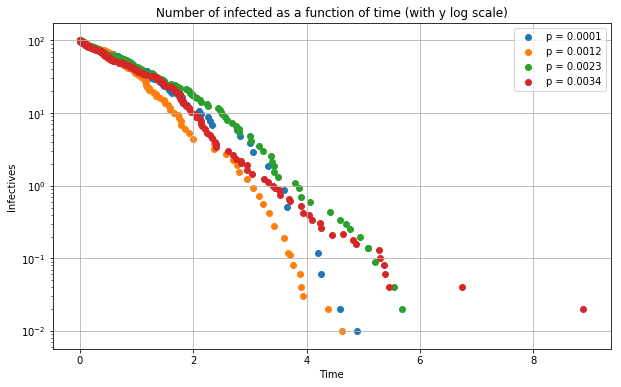

In [43]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_yscale('log')

ax.scatter(t_arr[0], I_arr[0], label='p = 0.0001')

ax.scatter(t_arr[1], I_arr[1], label='p = 0.0012')

ax.scatter(t_arr[2], I_arr[2], label='p = 0.0023')

ax.scatter(t_arr[3], I_arr[3], label='p = 0.0034')

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (with y log scale)')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

In [148]:
import numpy.polynomial.polynomial as poly

z = poly.polyfit(np.log(new_t_arr[0][1:]), np.log(new_I_arr[0][1:]), 1)
ffit = poly.polyval(np.linspace(0.01, 7, len(z)), np.log(z))

/Users/tsyrendylykova/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


In [168]:
new_t = np.asarray(new_t_arr[0][1:], dtype=float)
new_I = np.asarray(new_I_arr[0][1:], dtype=float)

In [169]:
log_new_I = np.log(new_I)
#log_new_I = np.log10(new_I)
log_new_t = new_t

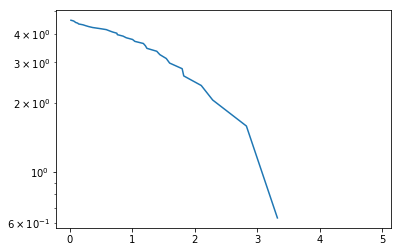

In [172]:
coefficients = poly.polyfit(log_new_t, log_new_I, 1)
polynomial = np.poly1d(coefficients)
#ys = polynomial(new_I)
plt.yscale('log')
plt.plot(log_new_t, log_new_I)
plt.show()

In [173]:
coefficients

array([ 5.1037139 , -1.56457821])

In [174]:
ffit = poly.polyval(np.linspace(0.01, 7, len(coefficients)), coefficients)

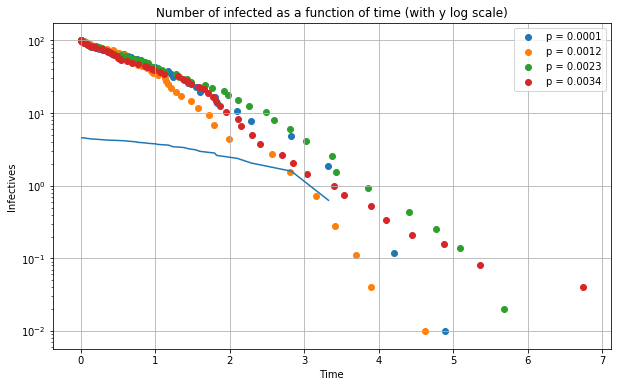

In [171]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_yscale('log')

ax.scatter(new_t_arr[0], new_I_arr[0], label='p = 0.0001')

ax.scatter(new_t_arr[1], new_I_arr[1], label='p = 0.0012')

ax.scatter(new_t_arr[2], new_I_arr[2], label='p = 0.0023')

ax.scatter(new_t_arr[3], new_I_arr[3], label='p = 0.0034')

ax.plot(log_new_t, log_new_I)

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (with y log scale)')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

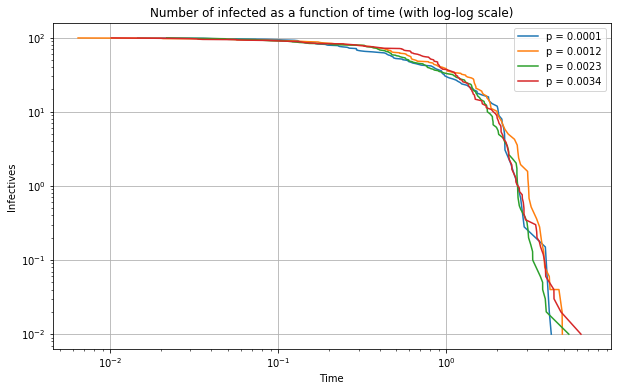

In [329]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(t_arr[0], I_arr[0], label='p = 0.0001')

ax.plot(t_arr[1], I_arr[1], label='p = 0.0012')

ax.plot(t_arr[2], I_arr[2], label='p = 0.0023')

ax.plot(t_arr[3], I_arr[3], label='p = 0.0034')

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (with log-log scale)')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

# Barabashi-Albert

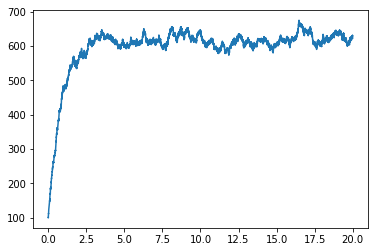

In [288]:
G = nx.barabasi_albert_graph(1000, 5)
initial_size = 100
gamma = 1.
tau = 0.3
t, S, I = Gillespie_SIS(G, tau, gamma, tmax = 20,
                        initial_infecteds = range(initial_size))

plt.plot(t, I)

In [28]:
network_arr = np.arange(100)
G_ensemble = []
for _ in network_arr:
    G_ensemble.append(nx.barabasi_albert_graph(1000, 5))

In [29]:
p_inf_arr = np.linspace(0.05, 0.5, 20)
p_inf_arr

array([0.05      , 0.07368421, 0.09736842, 0.12105263, 0.14473684,
       0.16842105, 0.19210526, 0.21578947, 0.23947368, 0.26315789,
       0.28684211, 0.31052632, 0.33421053, 0.35789474, 0.38157895,
       0.40526316, 0.42894737, 0.45263158, 0.47631579, 0.5       ])

In [31]:
initial_size = 100
gamma = 1.
t_stab = []
for prob in p_inf_arr:
    print("--------------------------------")
    print("infection probability: ", prob)
    
    inf_array = []
    for g in G_ensemble:
        t, S, I = SIS(g, prob, gamma, tmax = 20, initial_infecteds = range(initial_size))
        inf_array.append(I.tolist())
        
    #bug-fix: заполняем последними значениями списки зараженных для единообразия
    max_len = max([len(arr) for arr in inf_array])
    for arr in inf_array:
        if len(arr) < max_len:
            last_elem = arr[-1]
            for j in range(max_len - len(arr)):
                arr.append(last_elem)
    
    ens_inf = np.stack((inf_array), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    stab_time = get_stability_time(avrg_inf, len(t), 100, 0.1, 5)
    t_stab.append(t[stab_time - 1])

--------------------------------
infection probability:  0.05
--------------------------------
infection probability:  0.0736842105263158
--------------------------------
infection probability:  0.09736842105263158
--------------------------------
infection probability:  0.12105263157894737
--------------------------------
infection probability:  0.14473684210526316
--------------------------------
infection probability:  0.16842105263157897
--------------------------------
infection probability:  0.19210526315789472
--------------------------------
infection probability:  0.21578947368421053
--------------------------------
infection probability:  0.23947368421052634
--------------------------------
infection probability:  0.2631578947368421
--------------------------------
infection probability:  0.2868421052631579
--------------------------------
infection probability:  0.3105263157894737
--------------------------------
infection probability:  0.33421052631578946
------------------

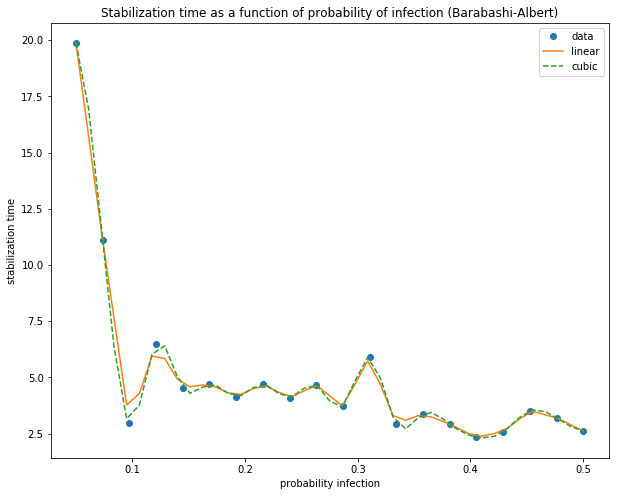

In [36]:
f1 = interp1d(p_inf_arr, t_stab)
f2 = interp1d(p_inf_arr, t_stab, kind='cubic')
f = plt.figure(figsize=(10,8))
xnew = np.linspace(0.05, 0.5, num=41, endpoint=True)
plt.title('Stabilization time as a function of probability of infection (Barabashi-Albert)')
plt.xlabel('probability infection')
plt.ylabel('stabilization time')
plt.plot(p_inf_arr, t_stab, 'o', xnew, f1(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

Text(0.5,1,'SIS model on Barabashi-Albert network (ensemble)')

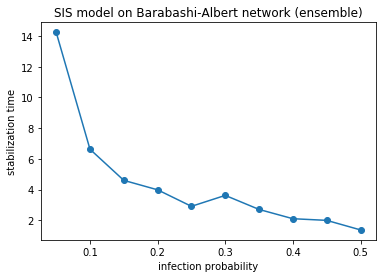

In [299]:
f = plt.figure()
plt.plot(p_inf_arr, t_stab, 'o-')
plt.xlabel('infection probability')
plt.ylabel('stabilization time')
plt.title('SIS model on Barabashi-Albert network (ensemble)')

In [38]:
p_inf_arr = np.linspace(0.02, 0.4, 20)

initial_size = 100
gamma = 1.
t_stab = []
t_arr = []
inf_frac = []
std_arr = []
for prob in p_inf_arr:
    print("--------------------------------")
    print("infection probability: ", prob)
    
    inf_array = []
    t_array = []
    for g in G_ensemble:
        t, S, I = SIS(g, prob, gamma, tmax = 20, initial_infecteds = range(initial_size))
        inf_array.append(I.tolist())
        t_array.append(t.tolist())
    
    #bug-fix: заполняем последними значениями списки зараженных для единообразия
    max_len_inf = max([len(arr) for arr in inf_array])
    for arr in inf_array:
        if len(arr) < max_len_inf:
            last_elem = arr[-1]
            for j in range(max_len_inf - len(arr)):
                arr.append(last_elem)
    
    #возьмем время с максимальной длиной
    t_max_len = [len(arr) for arr in t_array].index(max([len(arr) for arr in t_array]))
    t_arr.append(t_array[t_max_len])
    
    
    ens_inf = np.stack((inf_array), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    std = [np.std(lst) for lst in ens_inf]
    stab_time = get_stability_time(avrg_inf, len(t), 100, 0.1, 5)

    t_stab.append(stab_time)
    inf_frac.append(avrg_inf)
    std_arr.append(std)

--------------------------------
infection probability:  0.02
--------------------------------
infection probability:  0.04
--------------------------------
infection probability:  0.06
--------------------------------
infection probability:  0.08
--------------------------------
infection probability:  0.1
--------------------------------
infection probability:  0.12000000000000001
--------------------------------
infection probability:  0.13999999999999999
--------------------------------
infection probability:  0.16
--------------------------------
infection probability:  0.18
--------------------------------
infection probability:  0.19999999999999998
--------------------------------
infection probability:  0.22
--------------------------------
infection probability:  0.24
--------------------------------
infection probability:  0.26
--------------------------------
infection probability:  0.28
--------------------------------
infection probability:  0.30000000000000004
-----------

In [39]:
frac_arr = []
std_at_stab_time = []
for i, arr in enumerate(inf_frac):
    frac_arr.append(arr[t_stab[i]])
    std_at_stab_time.append(std[t_stab[i]])

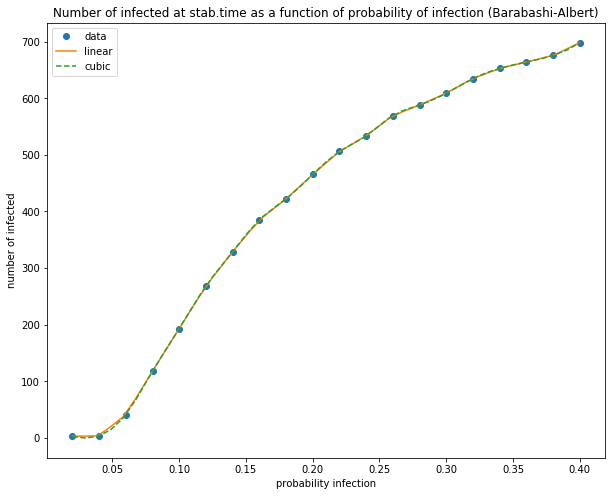

In [42]:
f1 = interp1d(p_inf_arr, frac_arr)
f2 = interp1d(p_inf_arr, frac_arr, kind='cubic')

f = plt.figure(figsize=(10,8))
xnew = np.linspace(0.02, 0.4, num=41, endpoint=True)
plt.title('Number of infected at stab.time as a function of probability of infection (Barabashi-Albert)')
plt.xlabel('probability infection')
plt.ylabel('number of infected')
plt.plot(p_inf_arr, frac_arr, 'o', xnew, f1(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

Text(0,0.5,'% of infected')

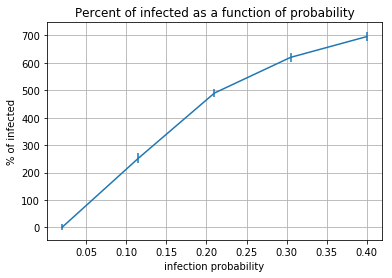

In [302]:
fig, ax = plt.subplots()
ax.errorbar(p_inf_arr, frac_arr, yerr = std_at_stab_time)
ax.grid(True)
ax.set_title('Percent of infected as a function of probability')
ax.set_xlabel('infection probability')
ax.set_ylabel('% of infected')

## Matrix adjacency

In [345]:
G = nx.barabasi_albert_graph(5000, 5)
A = nx.adjacency_matrix(G)
A = A.todense()
max_eigval = max(LA.eigvalsh(A))

In [346]:
max_eigval

25.52253059578642

In [347]:
tau = 1 / max_eigval
print("Epidemic threshold: ", tau)

Epidemic threshold:  0.039181067733349784


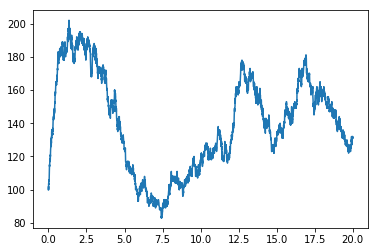

In [354]:
initial_size = 100
gamma = 1.
tau = 0.05
t, S, I = Gillespie_SIS(G, tau, gamma, tmax = 20,
                        initial_infecteds = range(initial_size))

plt.plot(t, I)

In [355]:
tau_arr = np.linspace(0.01, 0.1, 10)
tau_arr

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

In [356]:
initial_size = 100
gamma = 1.
tau = 0.004
I_arr, t_arr = [], []
for tau in (tau_arr):
    t, S, I = SIS(G, tau, gamma, tmax = 20,
                        initial_infecteds = range(initial_size))
    I_arr.append(I)
    t_arr.append(t)

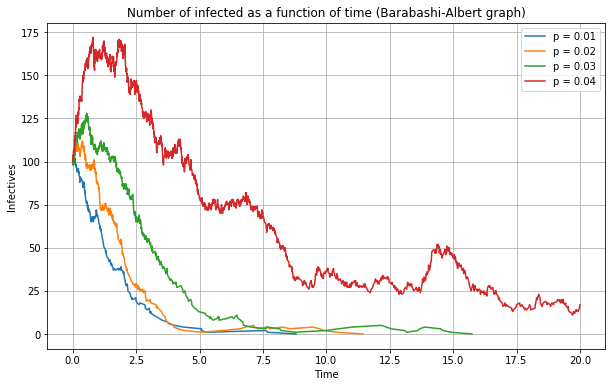

In [359]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_arr[0], I_arr[0], label='p = 0.01')

ax.plot(t_arr[1], I_arr[1], label='p = 0.02')

ax.plot(t_arr[2], I_arr[2], label='p = 0.03')

ax.plot(t_arr[3], I_arr[3], label='p = 0.04')

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (Barabashi-Albert graph)')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

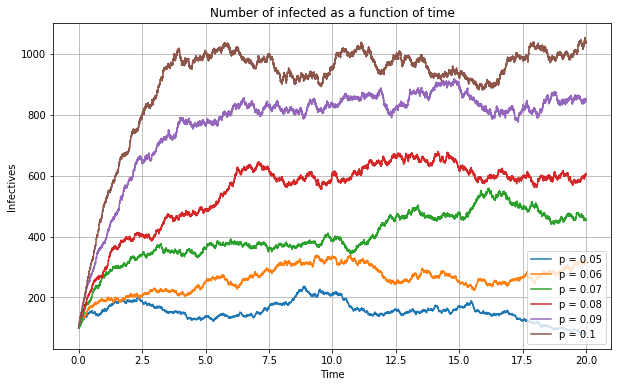

In [360]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_arr[4], I_arr[4], label='p = 0.05')

ax.plot(t_arr[5], I_arr[5], label='p = 0.06')

ax.plot(t_arr[6], I_arr[6], label='p = 0.07')

ax.plot(t_arr[7], I_arr[7], label='p = 0.08')

ax.plot(t_arr[8], I_arr[8], label='p = 0.09')

ax.plot(t_arr[9], I_arr[9], label='p = 0.1')

ax.legend(loc='lower right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

In [361]:
network_arr = np.arange(100)
N = 5000
m = 5
G_ensemble = []
for _ in network_arr:
    G_ensemble.append(nx.barabasi_albert_graph(N, m))

In [362]:
initial_size = 100
gamma = 1.
tau = 0.004
I_arr, t_arr = [], []
for tau in (tau_arr):
    I_tmp = []
    t_tmp = []
    for G in G_ensemble:
        t, S, I = SIS(G, tau, gamma, tmax = 20, initial_infecteds = range(initial_size))
        I_tmp.append(I.tolist())
        t_tmp.append(t.tolist())
    
    #дозаполним число зараженных, преобразуем в усредненный список
    max_len_inf = max([len(arr) for arr in I_tmp])
    for arr in I_tmp:
        if len(arr) < max_len_inf:
            last_elem = arr[-1]
            for j in range(max_len_inf - len(arr)):
                arr.append(last_elem)
    ens_inf = np.stack((I_tmp), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    I_arr.append(avrg_inf)
    
    #возьмем время с максимальной длиной
    t_max_len = [len(arr) for arr in t_tmp].index(max([len(arr) for arr in t_tmp]))
    t_arr.append(t_tmp[t_max_len])

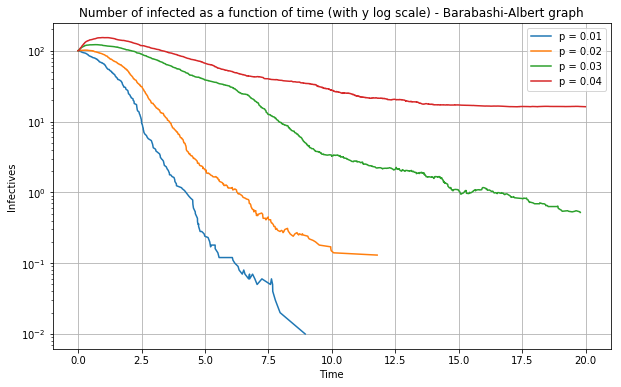

In [363]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_yscale('log')

ax.plot(t_arr[0], I_arr[0], label='p = 0.01')

ax.plot(t_arr[1], I_arr[1], label='p = 0.02')

ax.plot(t_arr[2], I_arr[2], label='p = 0.03')

ax.plot(t_arr[3], I_arr[3], label='p = 0.04')

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (with y log scale) - Barabashi-Albert graph')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

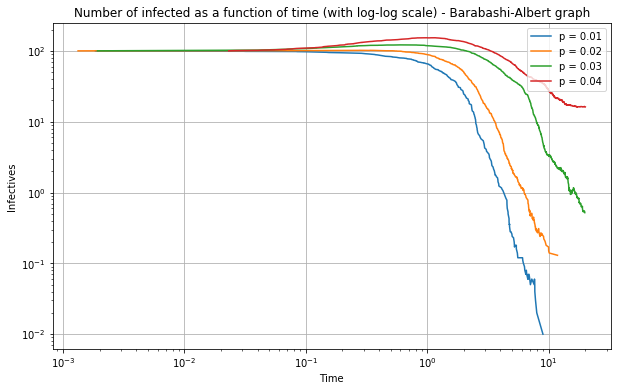

In [364]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(t_arr[0], I_arr[0], label='p = 0.01')

ax.plot(t_arr[1], I_arr[1], label='p = 0.02')

ax.plot(t_arr[2], I_arr[2], label='p = 0.03')

ax.plot(t_arr[3], I_arr[3], label='p = 0.04')

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (with log-log scale) - Barabashi-Albert graph')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

# Random Regular Graph

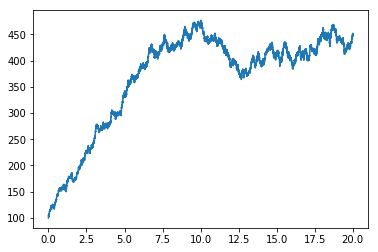

In [11]:
G = nx.random_regular_graph(5, 1000)
initial_size = 100
gamma = 1.
tau = 0.4
t, S, I = SIS(G, tau, gamma, tmax = 20, initial_infecteds = range(initial_size))

plt.plot(t, I)

In [7]:
network_arr = np.arange(100)
G_ensemble = []
for _ in network_arr:
    G_ensemble.append(nx.random_regular_graph(5, 1000))

In [8]:
p_inf_arr = np.linspace(0.05, 0.5, 20)
p_inf_arr

array([0.05      , 0.07368421, 0.09736842, 0.12105263, 0.14473684,
       0.16842105, 0.19210526, 0.21578947, 0.23947368, 0.26315789,
       0.28684211, 0.31052632, 0.33421053, 0.35789474, 0.38157895,
       0.40526316, 0.42894737, 0.45263158, 0.47631579, 0.5       ])

In [45]:
initial_size = 100
gamma = 1.
t_stab = []
for prob in p_inf_arr:
    print("--------------------------------")
    print("infection probability: ", prob)
    
    inf_array = []
    for g in G_ensemble:
        t, S, I = SIS(g, prob, gamma, tmax = 20, initial_infecteds = range(initial_size))
        inf_array.append(I.tolist())
        
    #bug-fix: заполняем последними значениями списки зараженных для единообразия
    max_len = max([len(arr) for arr in inf_array])
    for arr in inf_array:
        if len(arr) < max_len:
            last_elem = arr[-1]
            for j in range(max_len - len(arr)):
                arr.append(last_elem)
    
    ens_inf = np.stack((inf_array), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    stab_time = get_stability_time(avrg_inf, len(t), 100, 0.1, 5)
    t_stab.append(t[stab_time - 1])

--------------------------------
infection probability:  0.05
--------------------------------
infection probability:  0.0736842105263158
--------------------------------
infection probability:  0.09736842105263158
--------------------------------
infection probability:  0.12105263157894737
--------------------------------
infection probability:  0.14473684210526316
--------------------------------
infection probability:  0.16842105263157897
--------------------------------
infection probability:  0.19210526315789472
--------------------------------
infection probability:  0.21578947368421053
--------------------------------
infection probability:  0.23947368421052634
--------------------------------
infection probability:  0.2631578947368421
--------------------------------
infection probability:  0.2868421052631579
--------------------------------
infection probability:  0.3105263157894737
--------------------------------
infection probability:  0.33421052631578946
------------------

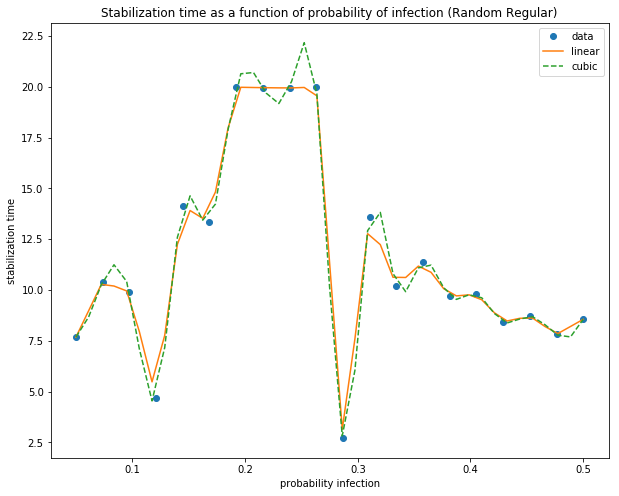

In [46]:
f1 = interp1d(p_inf_arr, t_stab)
f2 = interp1d(p_inf_arr, t_stab, kind='cubic')
f = plt.figure(figsize=(10,8))
xnew = np.linspace(0.05, 0.5, num=41, endpoint=True)
plt.title('Stabilization time as a function of probability of infection (Random Regular)')
plt.xlabel('probability infection')
plt.ylabel('stabilization time')
plt.plot(p_inf_arr, t_stab, 'o', xnew, f1(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

Text(0.5,1,'SIS model on Random regular graph network (ensemble)')

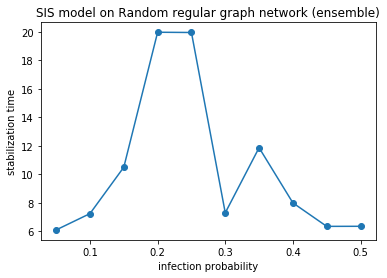

In [17]:
f = plt.figure()
plt.plot(p_inf_arr, t_stab, 'o-')
plt.xlabel('infection probability')
plt.ylabel('stabilization time')
plt.title('SIS model on Random regular graph network (ensemble)')

In [11]:
p_inf_arr = np.linspace(0.02, 0.5, 20)

initial_size = 100
gamma = 1.
t_stab = []
t_arr = []
inf_frac = []
std_arr = []
for prob in p_inf_arr:
    print("--------------------------------")
    print("infection probability: ", prob)
    
    inf_array = []
    t_array = []
    for g in G_ensemble:
        t, S, I = SIS(g, prob, gamma, tmax = 20, initial_infecteds = range(initial_size))
        inf_array.append(I.tolist())
        t_array.append(t.tolist())
    
    #bug-fix: заполняем последними значениями списки зараженных для единообразия
    max_len_inf = max([len(arr) for arr in inf_array])
    for arr in inf_array:
        if len(arr) < max_len_inf:
            last_elem = arr[-1]
            for j in range(max_len_inf - len(arr)):
                arr.append(last_elem)
    
    #возьмем время с максимальной длиной
    t_max_len = [len(arr) for arr in t_array].index(max([len(arr) for arr in t_array]))
    t_arr.append(t_array[t_max_len])
    
    
    ens_inf = np.stack((inf_array), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    std = [np.std(lst) for lst in ens_inf]
    stab_time = get_stability_time(avrg_inf, len(t), 100, 0.1, 5)

    t_stab.append(stab_time)
    inf_frac.append(avrg_inf)
    std_arr.append(std)

--------------------------------
infection probability:  0.02
--------------------------------
infection probability:  0.04526315789473684
--------------------------------
infection probability:  0.07052631578947369
--------------------------------
infection probability:  0.09578947368421052
--------------------------------
infection probability:  0.12105263157894737
--------------------------------
infection probability:  0.1463157894736842
--------------------------------
infection probability:  0.17157894736842103
--------------------------------
infection probability:  0.19684210526315787
--------------------------------
infection probability:  0.22210526315789472
--------------------------------
infection probability:  0.24736842105263157
--------------------------------
infection probability:  0.27263157894736845
--------------------------------
infection probability:  0.29789473684210527
--------------------------------
infection probability:  0.3231578947368421
----------------

In [18]:
for i in inf_frac:
    print(len(i))

147
189
257
339
563
652
987
1371
2361
3704
6052
7880
10135
12196
14468
15756
17842
18935
20205
21321


In [12]:
frac_arr = []
std_at_stab_time = []
for i, arr in enumerate(inf_frac):
    frac_arr.append(arr[t_stab[i]])
    std_at_stab_time.append(std[t_stab[i]])

f1 = interp1d(p_inf_arr, frac_arr)
f2 = interp1d(p_inf_arr, frac_arr, kind='cubic')

f = plt.figure(figsize=(10,8))
xnew = np.linspace(0.02, 0.4, num=41, endpoint=True)
plt.title('Number of infected at stab.time as a function of probability of infection (Barabashi-Albert)')
plt.xlabel('probability infection')
plt.ylabel('number of infected')
plt.plot(p_inf_arr, frac_arr, 'o', xnew, f1(xnew), '-', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

IndexError: list index out of range

In [176]:
G = nx.random_regular_graph(5, 1000)
A = nx.adjacency_matrix(G)
A = A.todense()
max_eigval = max(LA.eigvalsh(A))

In [177]:
max_eigval

5.000000000000006

In [178]:
1 / max_eigval

0.19999999999999976

In [183]:
tau_arr = np.linspace(0.1, 0.4, 10)
tau_arr

array([0.1       , 0.13333333, 0.16666667, 0.2       , 0.23333333,
       0.26666667, 0.3       , 0.33333333, 0.36666667, 0.4       ])

In [184]:
initial_size = 100
gamma = 1.
I_arr, t_arr = [], []
for tau in (tau_arr):
    t, S, I = SIS(G, tau, gamma, tmax = 20,
                        initial_infecteds = range(initial_size))
    I_arr.append(I)
    t_arr.append(t)

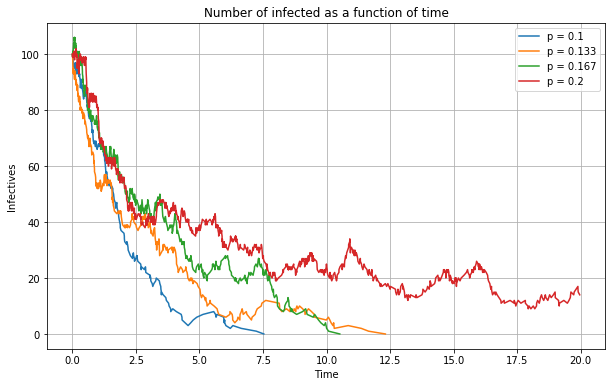

In [185]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(t_arr[0], I_arr[0], label= "p = " + str(round(tau_arr[0], 3)))

ax.plot(t_arr[1], I_arr[1], label= "p = " + str(round(tau_arr[1], 3)))

ax.plot(t_arr[2], I_arr[2], label= "p = " + str(round(tau_arr[2], 3)))

ax.plot(t_arr[3], I_arr[3], label= "p = " + str(round(tau_arr[3], 3)))

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

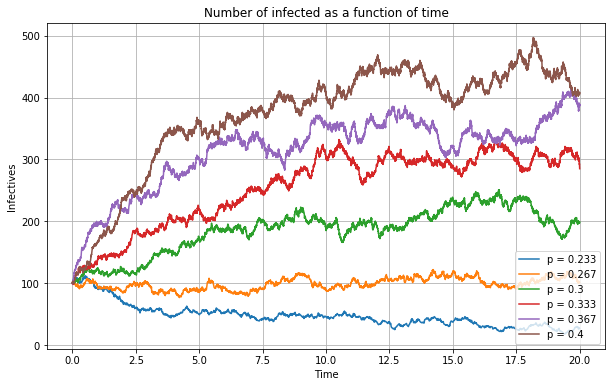

In [186]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_arr[4], I_arr[4], label= "p = " + str(round(tau_arr[4], 3)))

ax.plot(t_arr[5], I_arr[5], label= "p = " + str(round(tau_arr[5], 3)))

ax.plot(t_arr[6], I_arr[6], label= "p = " + str(round(tau_arr[6], 3)))

ax.plot(t_arr[7], I_arr[7], label= "p = " + str(round(tau_arr[7], 3)))

ax.plot(t_arr[8], I_arr[8], label= "p = " + str(round(tau_arr[8], 3)))

ax.plot(t_arr[9], I_arr[9], label= "p = " + str(round(tau_arr[9], 3)))

ax.legend(loc='lower right')
ax.grid(True)
ax.set_title('Number of infected as a function of time')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()

In [188]:
network_arr = np.arange(100)
G_ensemble = []
for _ in network_arr:
    G_ensemble.append(nx.random_regular_graph(5, 1000))

In [190]:
initial_size = 100
gamma = 1.
tau = 0.004
I_arr, t_arr = [], []
for tau in (tau_arr):
    I_tmp = []
    t_tmp = []
    for G in G_ensemble:
        t, S, I = SIS(G, tau, gamma, tmax = 20, initial_infecteds = range(initial_size))
        I_tmp.append(I.tolist())
        t_tmp.append(t.tolist())
    
    #дозаполним число зараженных, преобразуем в усредненный список
    max_len_inf = max([len(arr) for arr in I_tmp])
    for arr in I_tmp:
        if len(arr) < max_len_inf:
            last_elem = arr[-1]
            for j in range(max_len_inf - len(arr)):
                arr.append(last_elem)
    ens_inf = np.stack((I_tmp), axis=-1)
    avrg_inf = [np.mean(lst) for lst in ens_inf]
    I_arr.append(avrg_inf)
    
    #возьмем время с максимальной длиной
    t_max_len = [len(arr) for arr in t_tmp].index(max([len(arr) for arr in t_tmp]))
    t_arr.append(t_tmp[t_max_len])

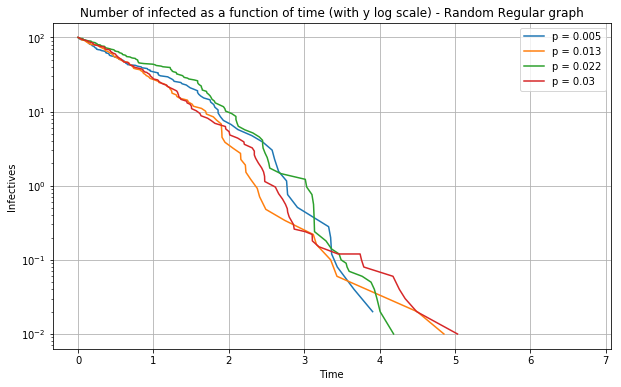

In [192]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_yscale('log')

ax.plot(t_arr[0], I_arr[0], label= "p = " + str(round(tau_arr[0], 3)))

ax.plot(t_arr[1], I_arr[1], label= "p = " + str(round(tau_arr[1], 3)))

ax.plot(t_arr[2], I_arr[2], label= "p = " + str(round(tau_arr[2], 3)))

ax.plot(t_arr[3], I_arr[3], label= "p = " + str(round(tau_arr[3], 3)))

ax.legend(loc='upper right')
ax.grid(True)
ax.set_title('Number of infected as a function of time (with y log scale) - Random Regular graph')
ax.set_xlabel('Time')
ax.set_ylabel('Infectives')
plt.show()